## Hacer pruebas:

In [57]:
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
import torch
import cv2


In [58]:
# Mi libreria:
from processLIDC import Patient

In [59]:
patient = Patient("LIDC-IDRI-0013")

Loading dicom files ... This may take a moment.


In [60]:
metodos = [m for m in dir(patient) if not '__' in m]
print(metodos) 

['get_all_nodules', 'get_mask', 'get_tensors', 'id_patient', 'imgs_scaled', 'mask', 'plot_mask', 'reconstruct_body', 'scale', 'scan', 'vol']


In [61]:
patient.get_all_nodules()

Paciente: LIDC-IDRI-0013
___________________________________
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 82
num. slices nodulo: 4
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 86
num. slices nodulo: 9
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 87
num. slices nodulo: 8
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 83
num. slices nodulo: 3
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 86
num. slices nodulo: 9
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 82
num. slices nodulo: 5
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 38
num. slices nodulo: 2
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 82
num. slices nodulo: 4
-----------
Paciente del nodulo: LIDC-IDRI-0013
Primera slice con el nodulo 89
num. slices nodulo: 7
-----------
Paciente del nodulo: LIDC-IDRI

In [62]:
patient.plot_mask()

In [63]:
patient.reconstruct_body(nodulos = True)

53136


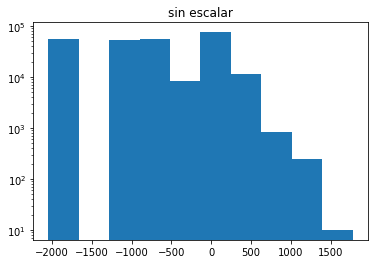

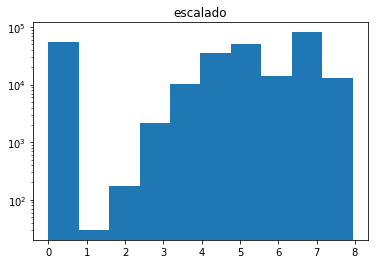

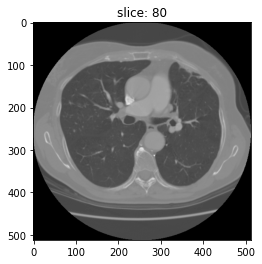

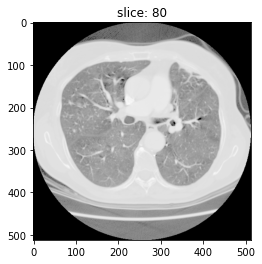

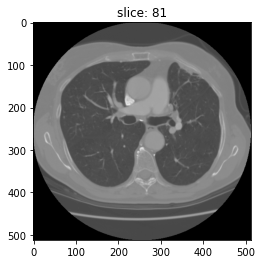

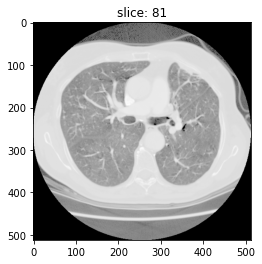

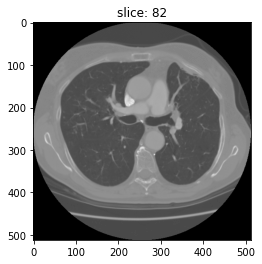

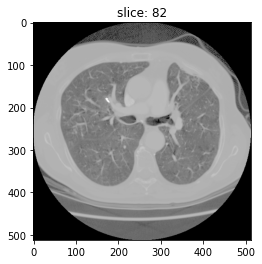

In [64]:
params = {'slices': (80,81,82), # (180, 185, 190)
          'plot': True,
          'with_mask': True}

patient.scale(**params)

## Inferencia:

In [65]:
# vuelvo a instanciar:
patient = Patient("LIDC-IDRI-0013")
patient.scale()

Loading dicom files ... This may take a moment.


1. Descargar el modelo, UNET. Entrenada con imagenes del cerebro.

In [66]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/faraujo/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Inspeccionemos el modelo:

In [67]:
print(model)
print(dir(model))

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

2. Obtener los tensores para pytorch (imagenes)

In [68]:
imgs, mask = patient.get_tensors(scaled=True)

In [69]:
print(imgs.shape)
print(imgs[0].shape)

torch.Size([125, 3, 256, 256])
torch.Size([3, 256, 256])


3. Seleccionar imagenes para hacer inferencia y hacerla:

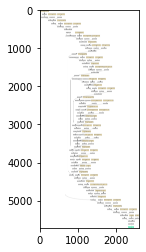

In [70]:
# slices:
primera = 80
ultima = 84

# Predecir:
pred = model(imgs[primera:ultima])

# Aprovechamos para obtener un grafico de la red:
graph = make_dot(pred, params=dict(model.named_parameters()))

# # Si queremos guardarla en la carpeta
# graph.render('model', format='png')

# obtenemos la imagen:
png_bytes = graph.pipe(format='png')
# Decodifica los bytes de PNG en un objeto de imagen OpenCV
nparr = np.frombuffer(png_bytes, np.uint8)
imagen = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
plt.imshow(imagen)
plt.show()


# graph.render('model', format='png')
pred = torch.round(pred).detach().numpy()

Veamos qué ha salido:

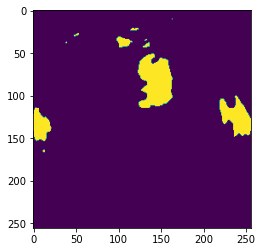

In [71]:
plt.imshow(pred[0].reshape(256,-1))
plt.show()

Es binaria la mascara predicha? Si, aunque preferiria un mapa de calor siendo proximo a 1 donde sea tumor y 0 donde no lo sea.

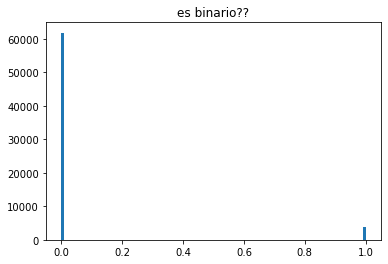

In [72]:
h = pred[0].reshape(-1)
plt.hist(h, bins = 100)
plt.title('es binario??')
plt.show()

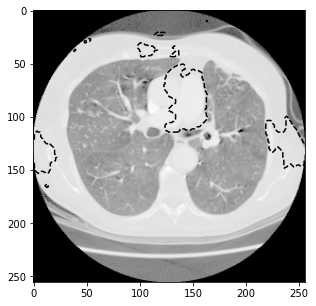

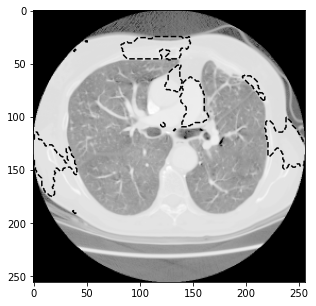

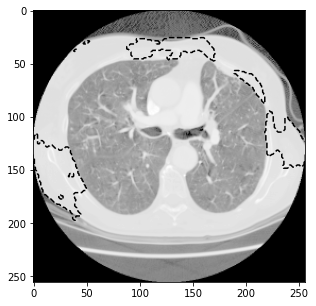

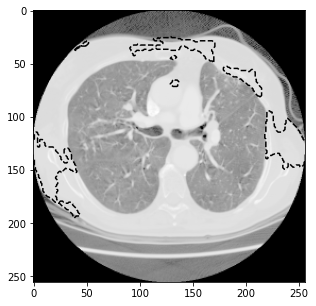

In [73]:
for k in range(ultima-primera):
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(imgs[k+primera, 0, :, :], cmap='gray')  # , alpha=0.5)

    for c in find_contours(pred[k, 0, :, :].astype(float), 0.5):
        plt.plot(c[:, 1], c[:, 0], '--k', label='Prediction')
    # plt.savefig(f"slice_pred_{k}.png")
    #  plt.close()